# Reinforcement Learning based Load Balancing 

Reinforcement learning has state,action and reward as the primary parameters. In our setting, the number of all possible combinations of STA mapping to AP makes number of states and actions. Since, we have 2 APs and 6 STAs in our setup number of states and actions are $2^6=64$

In [1]:
import os
import itertools
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
from scipy.io import loadmat,savemat
from numpy import random
from random import uniform
import shutil # to copy files to a speicific folder
''' import custom modules '''
from algorithms import Station_map,STA_clustering
''' copy file to desired folder'''
copy = False
filenum=5
from R_learning import R_learning

###  Import STA bitrate data
This bitrate are considered as upload bit rate and download bitrate per station and those are fed and fetched from APs.
Here we have the bitrate data for 200 Stations over a period of 2 days approximately.

In [2]:
UL_Rate = loadmat('UL_Rate.mat')
UL_R =  UL_Rate['UL_Rate'].T
DL_Rate = loadmat('DL_Rate.mat')
DL_R =  DL_Rate['DL_Rate'].T
NTs,N_STA = DL_R.shape # N_STA : Number of stations, NTs : Number of Timestames (length of the data for each station)

### Set NS3 network directory 

Since NS3 can only be run from the directory "Scratch" , hence if we have any NS3 network model we should store it in "$ns-3/ns-3.28/scratch$" folder.

$Note:$ the folder names could vary according to the NS3 installation

In [3]:
os.chdir('/home/koushik/ns-3/ns-3.28/')

### Initialize network simulation parameters 

In [10]:
nSTAs= 6 #int(N_STA) # number of stations in the network
nAPs = 2  # numbe of APs in the network
area = 15 # cross section area of the network, ex: 200X200 # parameter in meters
sim_Time =  2 # in seconds
visualize = False # visualize simulation 
MCS = -7 # -ve value means generate a different capacity for each AP

## Decision Tree Based station mapping  Equal number of channel assignment to each APs

In [5]:
''' a simple mapping of STA to AP: we get this from our algorithm '''
random.seed(1)
xloc  = random.randint(area,size=nSTAs)#random.uniform(area,size=nSTAs) #
random.seed(10)
yloc  = random.randint(area,size=nSTAs)#random.uniform(area,size=nSTAs)#
x =  xloc.reshape([nSTAs,1])
y =  yloc.reshape([nSTAs,1])
STA_loc =  np.append(x,y,axis=1);
AP_loc = np.array([[0,0],[area/2,0],[area,0],[area,area/2],[area,area],
                   [area/2,area],[0,area],[0,area/2],[area/2,area/2]]);
res={}
random.seed()

In [6]:
S_map = Station_map(area,nAPs,nSTAs,AP_loc)

### Initializing RL parameters

In [7]:
actions ={} # collect all possible actions based on station mapping
RL_model  =  R_learning(area,nAPs,nSTAs,AP_loc)
n_states  =  nAPs**nSTAs # totoal number of states in load balancing
#actions =  RL_model.get_action() # combined actions for all the agents 
n_actions =  nAPs**nSTAs# len(actions) # total number of combined actions 
agent_action = RL_model.action_set() # agent decision set for each action
epoch = 5000;
epoch1=10;
Q = ([[0.0 for i in range(n_actions)] for i in range(n_states)]) # initialize Q table
Reward=0;
R1 = np.array([[0.0 for i in range(epoch)] for i in range(epoch1)])

c_s = 0;
lst =  list(itertools.product(np.arange(nAPs), repeat=nSTAs)) # generate all possible mappings of STA--> AP
actions = dict(zip(np.arange(n_actions),np.array(lst)))
action =  random.randint(0,n_actions-1)
STA_map=actions[(action)];

Reinforcement learning based station mapping 


## Learn and optimize using RL over several timeslots

<IPython.core.display.Javascript object>


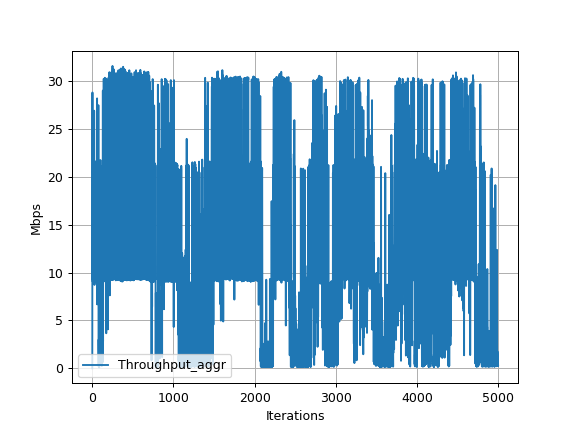

In [8]:
iter = epoch;
Tests = {'RL':iter}#, 'DT':iter,'EQ':iter+100,'rand':iter+100} # ['test': # of iterations]

for key in Tests:
    Dmean = 0;Dsum =0;
    Umean = 0;Usum =0;
    ''' real-time plotting '''
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()

    ''' initial mapping based on distance '''
    D = [];U = [];TH_aggr = [0];KB=[];
    TH_prev = 0
    D.append(Dmean);
    U.append(Umean);
    Best_STA = STA_map;
    Map_Hist = np.reshape(STA_map,[1,nSTAs])
    D_mean_best = 0;
    U_mean_best = 0;
    

    for j in range(Tests[key]):
        i=j;
        n_s =  action; # since we consider same number of action and states
        if action in actions.keys():#all ([x==y for x,y in zip(STA_map,actions[str(action)])]):
            STA_map=actions[(action)];

            
        inputs = {
                  'AP_xloc' :  pd.Series(AP_loc[:,0]),
                  'AP_yloc' :  pd.Series(AP_loc[:,1]),
                  'STA_xloc':  pd.Series(xloc),
                  'STA_yloc':  pd.Series(yloc),
                  'STA_map' :  pd.Series(STA_map),
                  'UL_Rate' :  pd.Series(UL_R[i,:]),
                  'DL_Rate' :  pd.Series(DL_R[i,:])   
                 }

        df1 = pd.DataFrame(inputs) 
        df1.to_csv('inputs.csv')

        ### Pass network parameters to NS3 and run network simulation
        if visualize:
            os.system('./waf --pyrun "scratch/NW_%s.py --nAPs=%s --nSTAs=%s --area=%s --simulationTime=%s --MCS=%s" --vis '
                  %(str(filenum),str(nAPs),str(nSTAs),str(area),str(sim_Time),str(MCS)))
        else:
            os.system('./waf --pyrun "scratch/NW_%s.py --nAPs=%s --nSTAs=%s --area=%s --simulationTime=%s --MCS=%s" '
                  %(str(filenum),str(nAPs),str(nSTAs),str(area),str(sim_Time),str(MCS)))

        df = pd.read_csv('NW_th.csv')


        Umean =  np.mean(df.values[:,-1]);
        Dmean =  np.mean(df.values[:,-2]);
        Usum = np.sum(df.values[:,-1]);
        Dsum = np.sum(df.values[:,-2]);
        #print('================================= TimeSlot- %d ===================================' %i)
        print('\rSTA map:{} and NW aggregated throughput {}'.format(STA_map,(Dsum+Usum)),end='\r') # print(df1['STA_map'])
        #print(df)
        #print('==================================================================================')

        if (Dsum+Usum)>TH_prev:
            #print('Got best map so far')
            Best_STA =  STA_map;        
            TH_prev = Dsum+Usum;
            #print('Best TH:',TH_prev)
        [Q,action] = RL_model.learn(Q,c_s,n_s,(Dsum+Usum),n_actions)
        c_s=n_s; # current state = next state;
        
        if i>0 or key=='DT'or key=='dist':
            KB.append(STA_map)
            D.append(Dsum);
            U.append(Usum);
            TH_aggr.append(Dsum+Usum);

        ''' plot results '''
        ax.clear()
        ax.plot(TH_aggr)
        fig.canvas.draw()
        plt.grid();
        plt.legend(['Throughput_aggr'],loc=3)
        plt.ylabel('Mbps')
        plt.xlabel('Iterations')
        plt.show()
        if MCS==abs(MCS):
            fig.savefig(key+'_SC.pdf') # similar capacity            
            res[key] = pd.Series(TH_aggr)
        else:
            fig.savefig(key+'_DC.pdf') # different capacity
            res[key] = pd.Series(TH_aggr)
        result = pd.DataFrame(res,columns=list(res.keys()))
        result.to_csv('RL_test2_'+str(MCS)+'.csv')


In [9]:
# save results to a csv file
result = pd.DataFrame(res,columns=list(res.keys()))
result.to_csv('RL_test1_'+str(MCS)+'.csv')

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

m = 1
n = 100
matrix = np.random.normal(0,1,m*n).reshape(m,n)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(0,100):
    ax.clear()
    ax.plot(matrix[0,:])
    fig.canvas.draw()